This file, intended for Python 2.7, reads in raw output from GP Microbiome and processes it, saving the data to csv files for use with up-to-date versions of Python. 

In [1]:
import pickle
from numpy import *


This code uses the output file 'example_output.p', created from running GP Microbiome on the example_data input files, so adjust your file names (or file paths, if the file is not in the same folder as this program) accordingly. The example data contains 10 time points for samples and 6 OTU's of bacteria, and predicted 13 time points: 10 of these are between sample time points and 3 are in the future. 
<br>

At the end of the program is a function that can be used to read in multiple output files at once. 

In [34]:
T,T_p,samples = pickle.load(open(r'C:\Users\Virginia\GPMicrobiome-master\example_output.p','r'))

In [3]:
#view a list of the variables in the output file
print samples.keys()

[u'G_d', u'G_i', u'F', u'Beta', u'eta_sq', u'inv_rho_sq', u'sigma_sq', u'rho_sq', u'Theta_G', u'Theta_G_i', u'lp__']


Below is an image of the output from the previous cell if predictions are made. These are explained in the research paper accompanying GPMicrobiome. Of primary interest are Theta_G, the noise-free compositions, and Theta_G_i, the noise-free compositions with predictions.
<br>
<img src= 'https://i.imgur.com/AbgLDRO.png' style='height:75px'>

In [4]:
#print the means of the Theta_G variable, and the Theta_G_i variable if predictions have been made
print samples['Theta_G'].mean(0).T
if samples.has_key('Theta_G_i'):
  print samples['Theta_G_i'].mean(0).T

[[0.04751675 0.07448655 0.01768101 0.09238814 0.18861926 0.07594025
  0.08391053 0.0697398  0.14064573 0.12945568]
 [0.13537543 0.13415304 0.0466478  0.1209646  0.14734226 0.10639203
  0.06938994 0.06628514 0.41193359 0.37277919]
 [0.04636825 0.12751477 0.02757002 0.10066794 0.19940899 0.15065145
  0.07755445 0.09546483 0.22477912 0.21227954]
 [0.20414512 0.13833795 0.03047529 0.05806151 0.13599022 0.06489398
  0.09623149 0.07818775 0.06389998 0.09880795]
 [0.50326826 0.43827061 0.85460989 0.52906836 0.02914884 0.49891596
  0.59905341 0.59103591 0.02373298 0.0496719 ]
 [0.06332619 0.08723709 0.02301599 0.09884944 0.29949043 0.10320632
  0.07386019 0.09928658 0.1350086  0.13700575]]
[[0.14102695 0.16250735 0.14426483 0.14909085 0.15505101 0.15224183
  0.1411767  0.13249091 0.14080339 0.14822108 0.14286403 0.15830326
  0.14744347]
 [0.1589444  0.15576454 0.16417252 0.15561684 0.15119944 0.15620812
  0.1670825  0.15090559 0.16413878 0.15990289 0.16589816 0.16043017
  0.1461392 ]
 [0.13524

Example Output, using the sample data with 10 time points and 13 prediction time points for 6 OTU's. 
<br>
Blue arrows indicate where the arrays for Theta_G and Theta_G_i begin.
<img src='https://i.imgur.com/IETB4LK.png' style='height:400px'>

In [6]:
#Examine the time points array to make sure it was saved correctly. 
#Our project used timepoints based on the number of days since the first sample, so I did the same for the example file. 
T

array([   0.,  442.,  620.,  879.,  991., 1087., 1255., 1379., 1492.,
       1617.])

In [7]:
#Convert the array to a list
T=T.tolist()

In [8]:
#Examine the prediction time points array to make sure it was saved correctly
T_p

array([ 147.,  294.,  531.,  749.,  935., 1039., 1171., 1317., 1435.,
       1554., 1797., 1977., 2157.])

In [9]:
#Convert the array to a list
T_p=T_p.tolist()

In [10]:
#Make a single list for both sets of time points, for reference 
T_both = T+T_p
T_both

[0.0,
 442.0,
 620.0,
 879.0,
 991.0,
 1087.0,
 1255.0,
 1379.0,
 1492.0,
 1617.0,
 147.0,
 294.0,
 531.0,
 749.0,
 935.0,
 1039.0,
 1171.0,
 1317.0,
 1435.0,
 1554.0,
 1797.0,
 1977.0,
 2157.0]

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

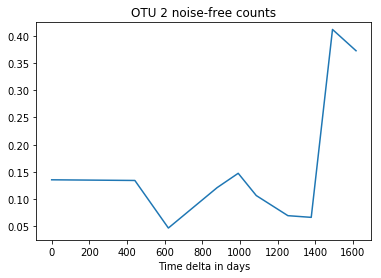

In [20]:
#Do a quick exploratory plot of one of the OTU's, specifying y-axis limits if desired
plt.plot(T,samples['Theta_G'].mean(0).T[1])
plt.title('OTU 2 noise-free counts')
plt.xlabel('Time delta in days')
#plt.ylim(0.025,.425)
plt.show()

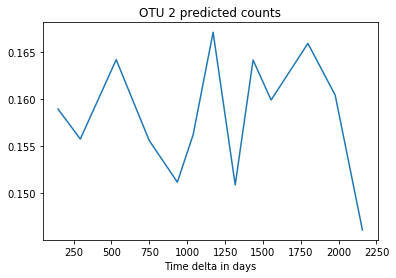

In [22]:
#Do a second quick plot, of the predicted values for the same OTU, in the same fashion
plt.plot(T_p,samples['Theta_G_i'].mean(0).T[1])
plt.title('OTU 2 predicted counts')
plt.xlabel('Time delta in days')
#plt.ylim(0.025,.425)
plt.show()

In [23]:
import pandas as pd

In [27]:
#Create a data frame with the timepoints in the first row and the OTU's in the following rows
df=pd.DataFrame(samples['Theta_G'].mean(0).T, columns=[i for i in range(len(T))], index=[i+1 for i in range(6)])
df.loc[0] = T
df=df.sort_index()
df.head()


,0,1,2,3,4,5,6,7,8,9
0,0.000000,442.000000,620.000000,879.000000,991.000000,1087.000000,1255.000000,1379.000000,1492.000000,1617.000000
1,0.047517,0.074487,0.017681,0.092388,0.188619,0.075940,0.083911,0.069740,0.140646,0.129456
2,0.135375,0.134153,0.046648,0.120965,0.147342,0.106392,0.069390,0.066285,0.411934,0.372779
3,0.046368,0.127515,0.027570,0.100668,0.199409,0.150651,0.077554,0.095465,0.224779,0.212280
4,0.204145,0.138338,0.030475,0.058062,0.135990,0.064894,0.096231,0.078188,0.063900,0.098808


Example data frame using the sample data
<img src='https://i.imgur.com/6U9XUzO.png' style='height:160px'>

In [111]:
#Save to csv for re-importing into code using an up-to-date version of Python. 
#Remember to specify a file path if you want it in a particular folder. 
df.to_csv('example.csv', index=False)

In [29]:
#Create a second data frame for just the prediction time points and values, with the same format as before but column values starting 
#after the last value of the other data frame's columns
df2=pd.DataFrame(samples['Theta_G_i'].mean(0).T, columns=[i for i in range(len(T),len(T)+len(T_p))], index=[i+1 for i in range(6)])
df2.loc[0] = T_p
df2 = df2.sort_index()
df2.head()

,10,11,12,13,14,15,16,17,18,19,20,21,22
0,147.000000,294.000000,531.000000,749.000000,935.000000,1039.000000,1171.000000,1317.000000,1435.000000,1554.000000,1797.000000,1977.000000,2157.000000
1,0.141027,0.162507,0.144265,0.149091,0.155051,0.152242,0.141177,0.132491,0.140803,0.148221,0.142864,0.158303,0.147443
2,0.158944,0.155765,0.164173,0.155617,0.151199,0.156208,0.167082,0.150906,0.164139,0.159903,0.165898,0.160430,0.146139
3,0.135241,0.135388,0.145034,0.140634,0.141929,0.153736,0.141846,0.143664,0.140465,0.141662,0.138703,0.135336,0.134560
4,0.171019,0.169872,0.162914,0.175218,0.166273,0.166517,0.166613,0.175385,0.180555,0.174343,0.171803,0.172512,0.172133


In [113]:
#Save to csv as before. 
df2.to_csv('example_pred.csv',index=False)

In [30]:
#Combine the two data frames 
dfboth = pd.concat([df, df2], axis=1, sort=False)
dfboth.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,0.000000,442.000000,620.000000,879.000000,991.000000,1087.000000,1255.000000,1379.000000,1492.000000,1617.000000,...,749.000000,935.000000,1039.000000,1171.000000,1317.000000,1435.000000,1554.000000,1797.000000,1977.000000,2157.000000
1,0.047517,0.074487,0.017681,0.092388,0.188619,0.075940,0.083911,0.069740,0.140646,0.129456,...,0.149091,0.155051,0.152242,0.141177,0.132491,0.140803,0.148221,0.142864,0.158303,0.147443
2,0.135375,0.134153,0.046648,0.120965,0.147342,0.106392,0.069390,0.066285,0.411934,0.372779,...,0.155617,0.151199,0.156208,0.167082,0.150906,0.164139,0.159903,0.165898,0.160430,0.146139
3,0.046368,0.127515,0.027570,0.100668,0.199409,0.150651,0.077554,0.095465,0.224779,0.212280,...,0.140634,0.141929,0.153736,0.141846,0.143664,0.140465,0.141662,0.138703,0.135336,0.134560
4,0.204145,0.138338,0.030475,0.058062,0.135990,0.064894,0.096231,0.078188,0.063900,0.098808,...,0.175218,0.166273,0.166517,0.166613,0.175385,0.180555,0.174343,0.171803,0.172512,0.172133
5,0.503268,0.438271,0.854610,0.529068,0.029149,0.498916,0.599053,0.591036,0.023733,0.049672,...,0.263506,0.268758,0.240535,0.268628,0.278014,0.253870,0.260834,0.263487,0.257528,0.283093
6,0.063326,0.087237,0.023016,0.098849,0.299490,0.103206,0.073860,0.099287,0.135009,0.137006,...,0.115934,0.116790,0.130762,0.114653,0.119541,0.120168,0.115036,0.117245,0.115890,0.116632


In [115]:
#Save to csv for use later with an up-to-date version of Python
dfboth.to_csv('example_both.csv', index=False)

In [37]:
#Simple function that could be used to create the 3 files quickly, or read several files in using dictionaries and a loop
def file_create(T,T_p,samples,name):
    T=T.tolist()
    T_p=T_p.tolist()
    df=pd.DataFrame(samples['Theta_G'].mean(0).T, columns=[i for i in range(len(T))], index=[i+1 for i in range(6)])
    df.loc[0] = T
    df=df.sort_index()
    df.to_csv('{}.csv'.format(name), index=False)
    df2=pd.DataFrame(samples['Theta_G_i'].mean(0).T, columns=[i for i in range(len(T),len(T)+len(T_p))], index=[i+1 for i in range(6)])
    df2.loc[0] = T_p
    df2 = df2.sort_index()
    df2.to_csv('{}_pred.csv'.format(name), index=False)
    dfboth = pd.concat([df, df2], axis=1, sort=False)
    dfboth.to_csv('{}_both.csv'.format(name), index=False)

In [38]:
file_create(T,T_p,samples,'example')